In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import datasets

In [3]:
from datasets import Features, Value, ClassLabel
from datasets import load_dataset, Image

class_names = ['image']
ft = Features({'image': Image(decode=True, id=None), 'label': ClassLabel(names=['625819a92a2466ab6181a2fb5271ae99c740b4f0e4b9bc97bcfa01ef4ed9666f', '739a87d55867610f9341b5706e0702effaca6404b58a85184530e97674925c11', '912b0ea8f91a77c03100a11b064c6352c96b157402b302f1d4e2fdd0b19ca0da', 'c130f98c73856f51a8a5d53d5566171b4f3b2b64b733b9392b3a4c4387af0208', 'ca0306348357abce2f22db92a9d60f3c7d65a4b6a94e9f8b596b33c0bb41d22c'], id=None)})

dataset = load_dataset("DucHaiten/PIXAR-SDXL", features=ft)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1851 [00:00<?, ? examples/s]

In [4]:
train_dataset = dataset['train']

In [5]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1851
})

In [6]:
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
transform = transforms.Resize((1024,1024))

class PixarDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.asarray(item["image"]).astype(np.float32)/255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        image = transform(image)
        return image

In [7]:
trainDataset = PixarDataset(dataset=train_dataset)

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(trainDataset, batch_size=2, shuffle=True)

In [9]:
import torch.nn.functional as F

In [10]:
import torch
import torch.nn as nn

class UNetDiffusion(nn.Module):
    def __init__(self):
        super(UNetDiffusion, self).__init__()

        # Down-sampling layers
        self.down1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Up-sampling layers
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU()
        )

        # Final convolution
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Down-sampling
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)

        # Up-sampling
        x_up3 = self.up3(x3)
        x_up2 = self.up2(torch.cat([x_up3, x2], dim=1))
        x_up1 = self.up1(torch.cat([x_up2, x1], dim=1))

        # Final convolution
        out = self.final_conv(x_up1)

        return out

In [11]:
IMG_SIZE = 1024     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 2  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

In [12]:
def show_examples(x):
    plt.figure(figsize=(10, 10))
    print(x.shape)
    imgs = (255*(x.permute(0,2,3,1))).numpy().astype('uint8')
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

In [13]:
import matplotlib.pyplot as plt

torch.Size([2, 3, 1024, 1024])


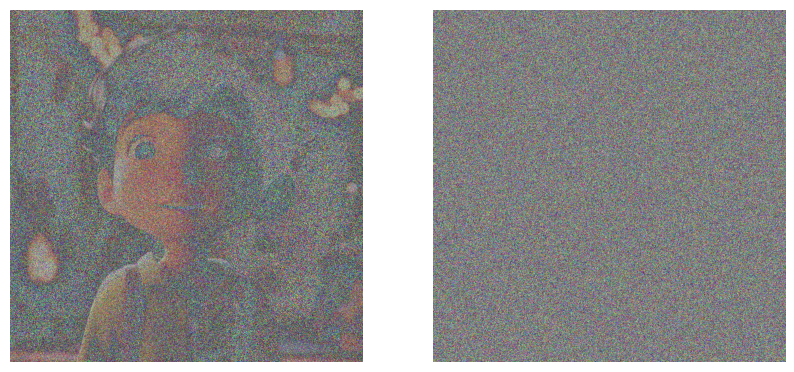

In [17]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(2)             # random for training data
x = next(iter(train_dataloader))
a, b = forward_noise(x, t)
show_examples(a)

torch.Size([2, 3, 1024, 1024])


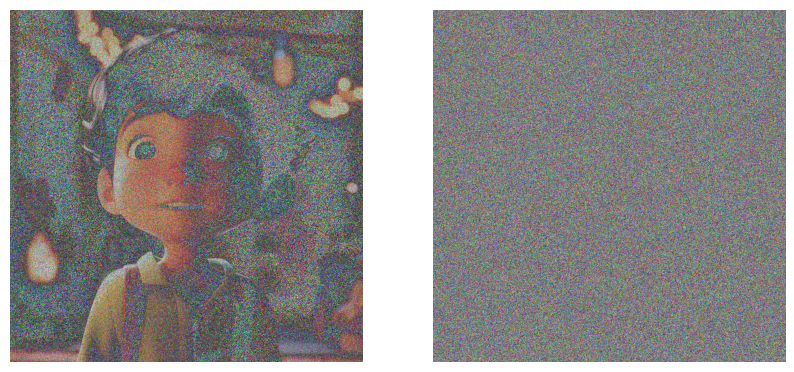

In [18]:
show_examples(b)

In [19]:
from tqdm.auto import trange, tqdm

In [20]:
# Parameters
num_epochs = 50
batch_size = 2
learning_rate = 0.001
image_shape = (1024, 1024)

In [21]:
# Testing the model
model = UNetDiffusion().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
loss = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, inputs in enumerate(train_dataloader):
        optimizer.zero_grad()
        x_ts = generate_ts(len(inputs))
        x_a, x_b = forward_noise(inputs, x_ts)
        x_ts = torch.from_numpy(x_ts).view(-1, 1).float().cuda()
        x_a = x_a.float().cuda()
        x_b = x_b.float().cuda()

        outputs = model(x_a)
        loss = torch.mean(torch.abs(outputs - x_b)) #criterion(outputs, x_b)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss.append(epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader)}")

Epoch 1/50, Loss: 0.2656769619281072
Epoch 2/50, Loss: 0.2133390633771538
Epoch 3/50, Loss: 0.19371988571633145
Epoch 4/50, Loss: 0.17889592534667342
Epoch 5/50, Loss: 0.16977041861601577
Epoch 6/50, Loss: 0.16064292580677803
Epoch 7/50, Loss: 0.15916355822404313
Epoch 8/50, Loss: 0.15253898917373518
Epoch 9/50, Loss: 0.14859520197196283
Epoch 10/50, Loss: 0.150888791535106
Epoch 11/50, Loss: 0.13865946081806915
Epoch 12/50, Loss: 0.14434321001815745
Epoch 13/50, Loss: 0.1389487405120522
Epoch 14/50, Loss: 0.13992859412298475
Epoch 15/50, Loss: 0.13709032339029834
Epoch 16/50, Loss: 0.13718108921543118
Epoch 17/50, Loss: 0.1333093110926562
Epoch 18/50, Loss: 0.1319598063311618
Epoch 19/50, Loss: 0.13005532668481057
Epoch 20/50, Loss: 0.13169336888021901
Epoch 21/50, Loss: 0.1284480735349829
Epoch 22/50, Loss: 0.13028436376196262
Epoch 23/50, Loss: 0.12701900261926985
Epoch 24/50, Loss: 0.12884010470092103
Epoch 25/50, Loss: 0.1272533053359254
Epoch 26/50, Loss: 0.1262192955928539
Epoch

In [ ]:
torch.save(model.state_dict(), 'model.pt')

[]

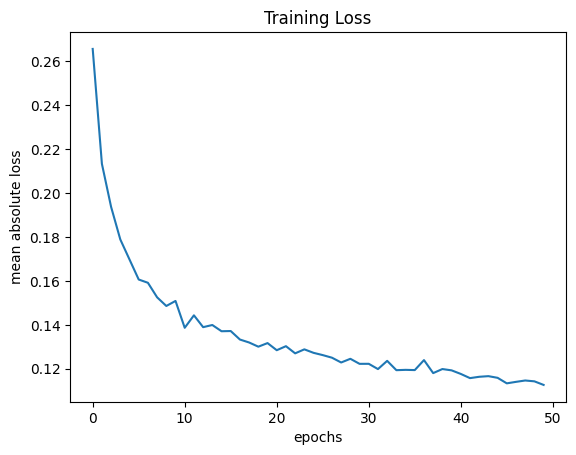

In [41]:
plt.plot(loss)
plt.xlabel("epochs")
plt.ylabel("mean absolute loss")
plt.title("Training Loss")
plt.plot()

### Inference

In [22]:
model.load_state_dict(torch.load("/content/model.pt"))

<All keys matched successfully>

In [25]:
def predict_step(x):
    xs = []

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x)
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = (255*(xs.permute(0,2,3,1))).numpy().astype('uint8')
    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

  0%|          | 0/16 [00:00<?, ?it/s]

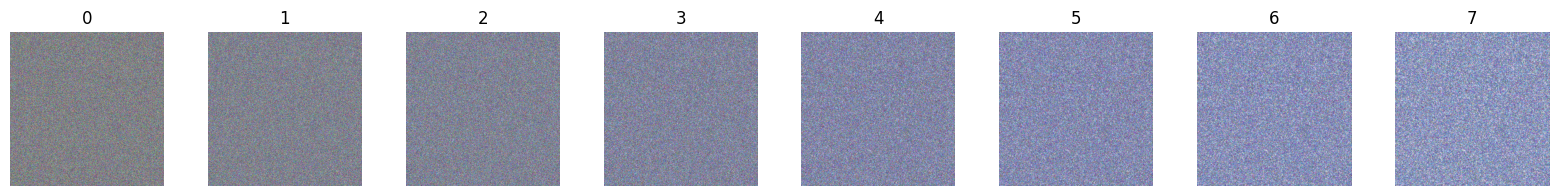

In [27]:
x = torch.randn(size=(1, 3, IMG_SIZE, IMG_SIZE), device=device)
predict_step(x)

  0%|          | 0/16 [00:00<?, ?it/s]

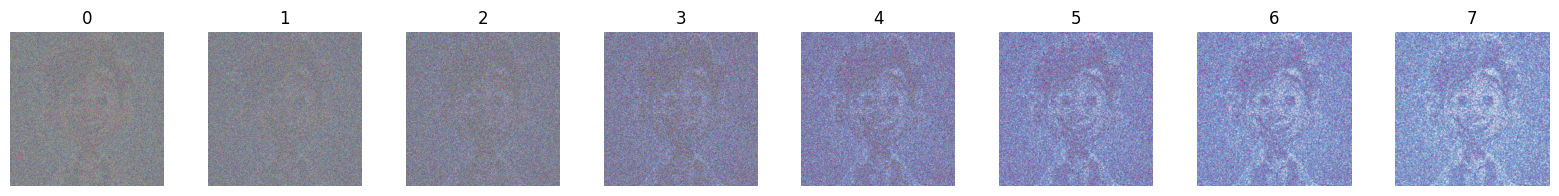

In [32]:
a = np.array([0.8])
noise = np.random.normal(size=x.shape)  # noise mask
a = a.reshape((-1, 1, 1, 1))
x = trainDataset[10]
noise_image = x * (1 - a) + noise * a
noise_image = noise_image.float().cuda()
predict_step(noise_image)

  0%|          | 0/16 [00:00<?, ?it/s]

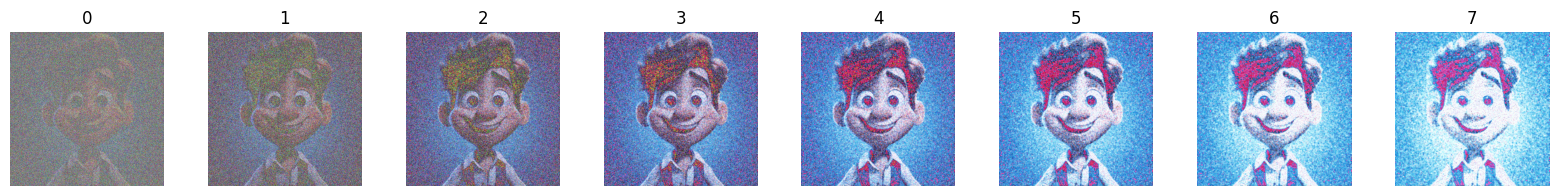

In [33]:
a = np.array([0.5])
noise = np.random.normal(size=x.shape)  # noise mask
a = a.reshape((-1, 1, 1, 1))
x = trainDataset[10]
noise_image = x * (1 - a) + noise * a
noise_image = noise_image.float().cuda()
predict_step(noise_image)